# Natural Language Processing with Disaster Tweets

Jiajie Xu, 11Mar2022

# Overview

## Business Problem

Our local emergency department want to use social media to trace emergency occur. For example, when people post a tweet online, local police or 911 can read the news and come out for help immediately. However, there are too many text info online to sort by human, so we need to generate a sufficient machine learning approach. 

## Business proposal

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

## Business solution

By using Natual language Processing model, we can recognize tweets and get real disaster from social media. In this way, we may able to help emergency ambulance locate and rescue on time. 

# Data Loading and cleaning

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.7.0
Default GPU Device: /device:GPU:0


## Import data

In [2]:
import sys

In [3]:
#need to install worlcloud on local pc by: 
#conda install -c conda-forge wordcloud=1.6.0 
#need to install: pip install transformers
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import os
import numpy as np
import pandas as pd

import text_hammer as th
import seaborn as sns
import matplotlib.pyplot as plt
import re
import en_core_web_sm
import pydot
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from collections import defaultdict

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from transformers import AutoTokenizer,TFBertModel
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn import metrics

max_len = 36

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense
from keras.preprocessing.text import Tokenizer

from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [4]:
train_data = pd.read_csv('train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('test.csv',usecols=['id','text'])
sample_data = pd.read_csv('sample_submission.csv')

In [5]:
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_data.shape

(7613, 3)

In [8]:
test_data.shape

(3263, 2)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB


In [11]:
train_data.isnull().sum()

id        0
text      0
target    0
dtype: int64

In [12]:
test_data.isnull().sum()

id      0
text    0
dtype: int64

## data cleaning

In [13]:
#data cleaning
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [14]:
train_cleaned_data = text_preprocessing(train_data,'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [15]:
test_cleaned_data = text_preprocessing(test_data,'text')

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

In [16]:
train_cleaned_data.head(30)

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update california hwy 20 closed in b...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,im on top of the hill and i can see a fire in ...,1
8,14,theres an emergency evacuation happening now i...,1
9,15,im afraid that the tornado is coming to our area,1


In [17]:
stop_words = set(stopwords.words('english'))
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# EDA

## Disaster Tweets wordcloud 

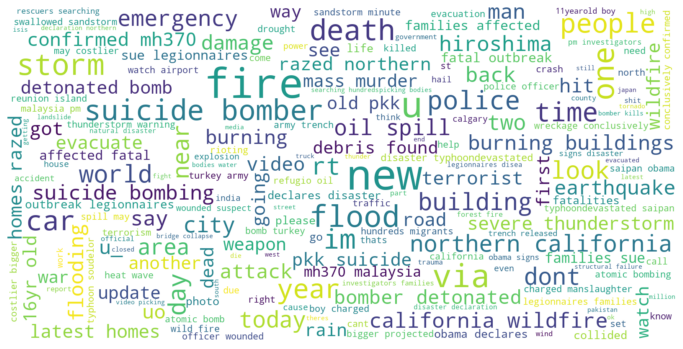

In [18]:
disaster_tweets = train_data[train_data.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Positive tweets wordcloud

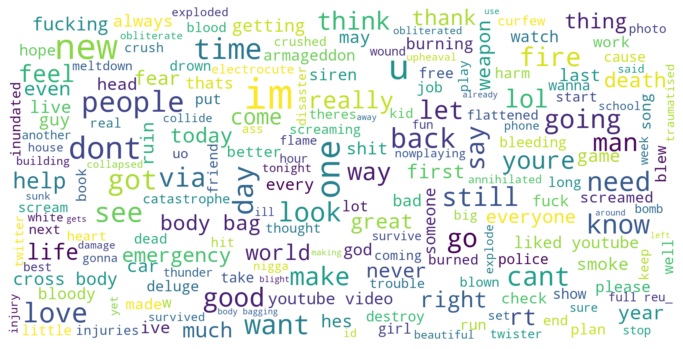

In [19]:
# Positive tweets wordcloud
formal_tweets = train_data[train_data.target == 0]
formal_string = []
for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Visualizing data distribution 

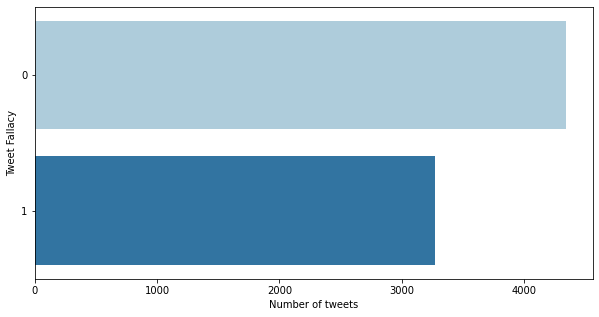

In [20]:
#Visualizing class distribution 
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = train_data,palette="Paired")
plt.ylabel("Tweet Fallacy")
plt.xlabel("Number of tweets")
plt.show()

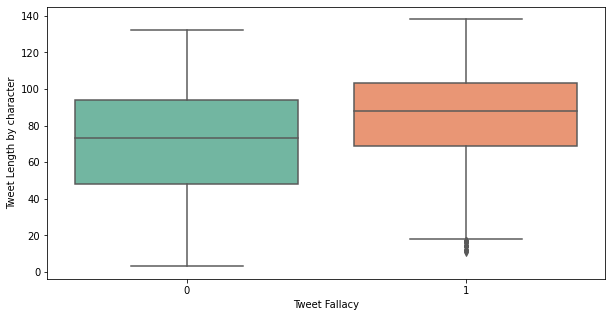

In [21]:
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set2")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet Length by character")
plt.show()

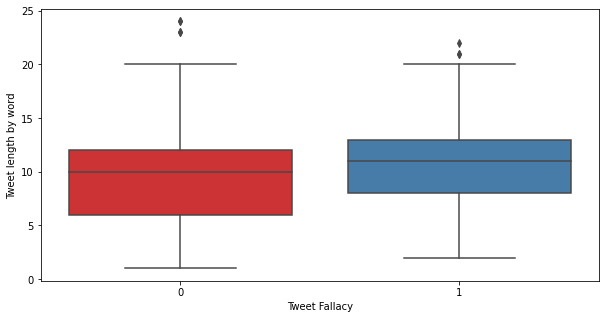

In [22]:
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

In [23]:
# word_count
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
#Stopwords are the English words which does not add much meaning to a sentence.

train_data['stop_word_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_data['url_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data['mean_word_length'] = train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['text'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['text'].apply(lambda x: len(str(x)))

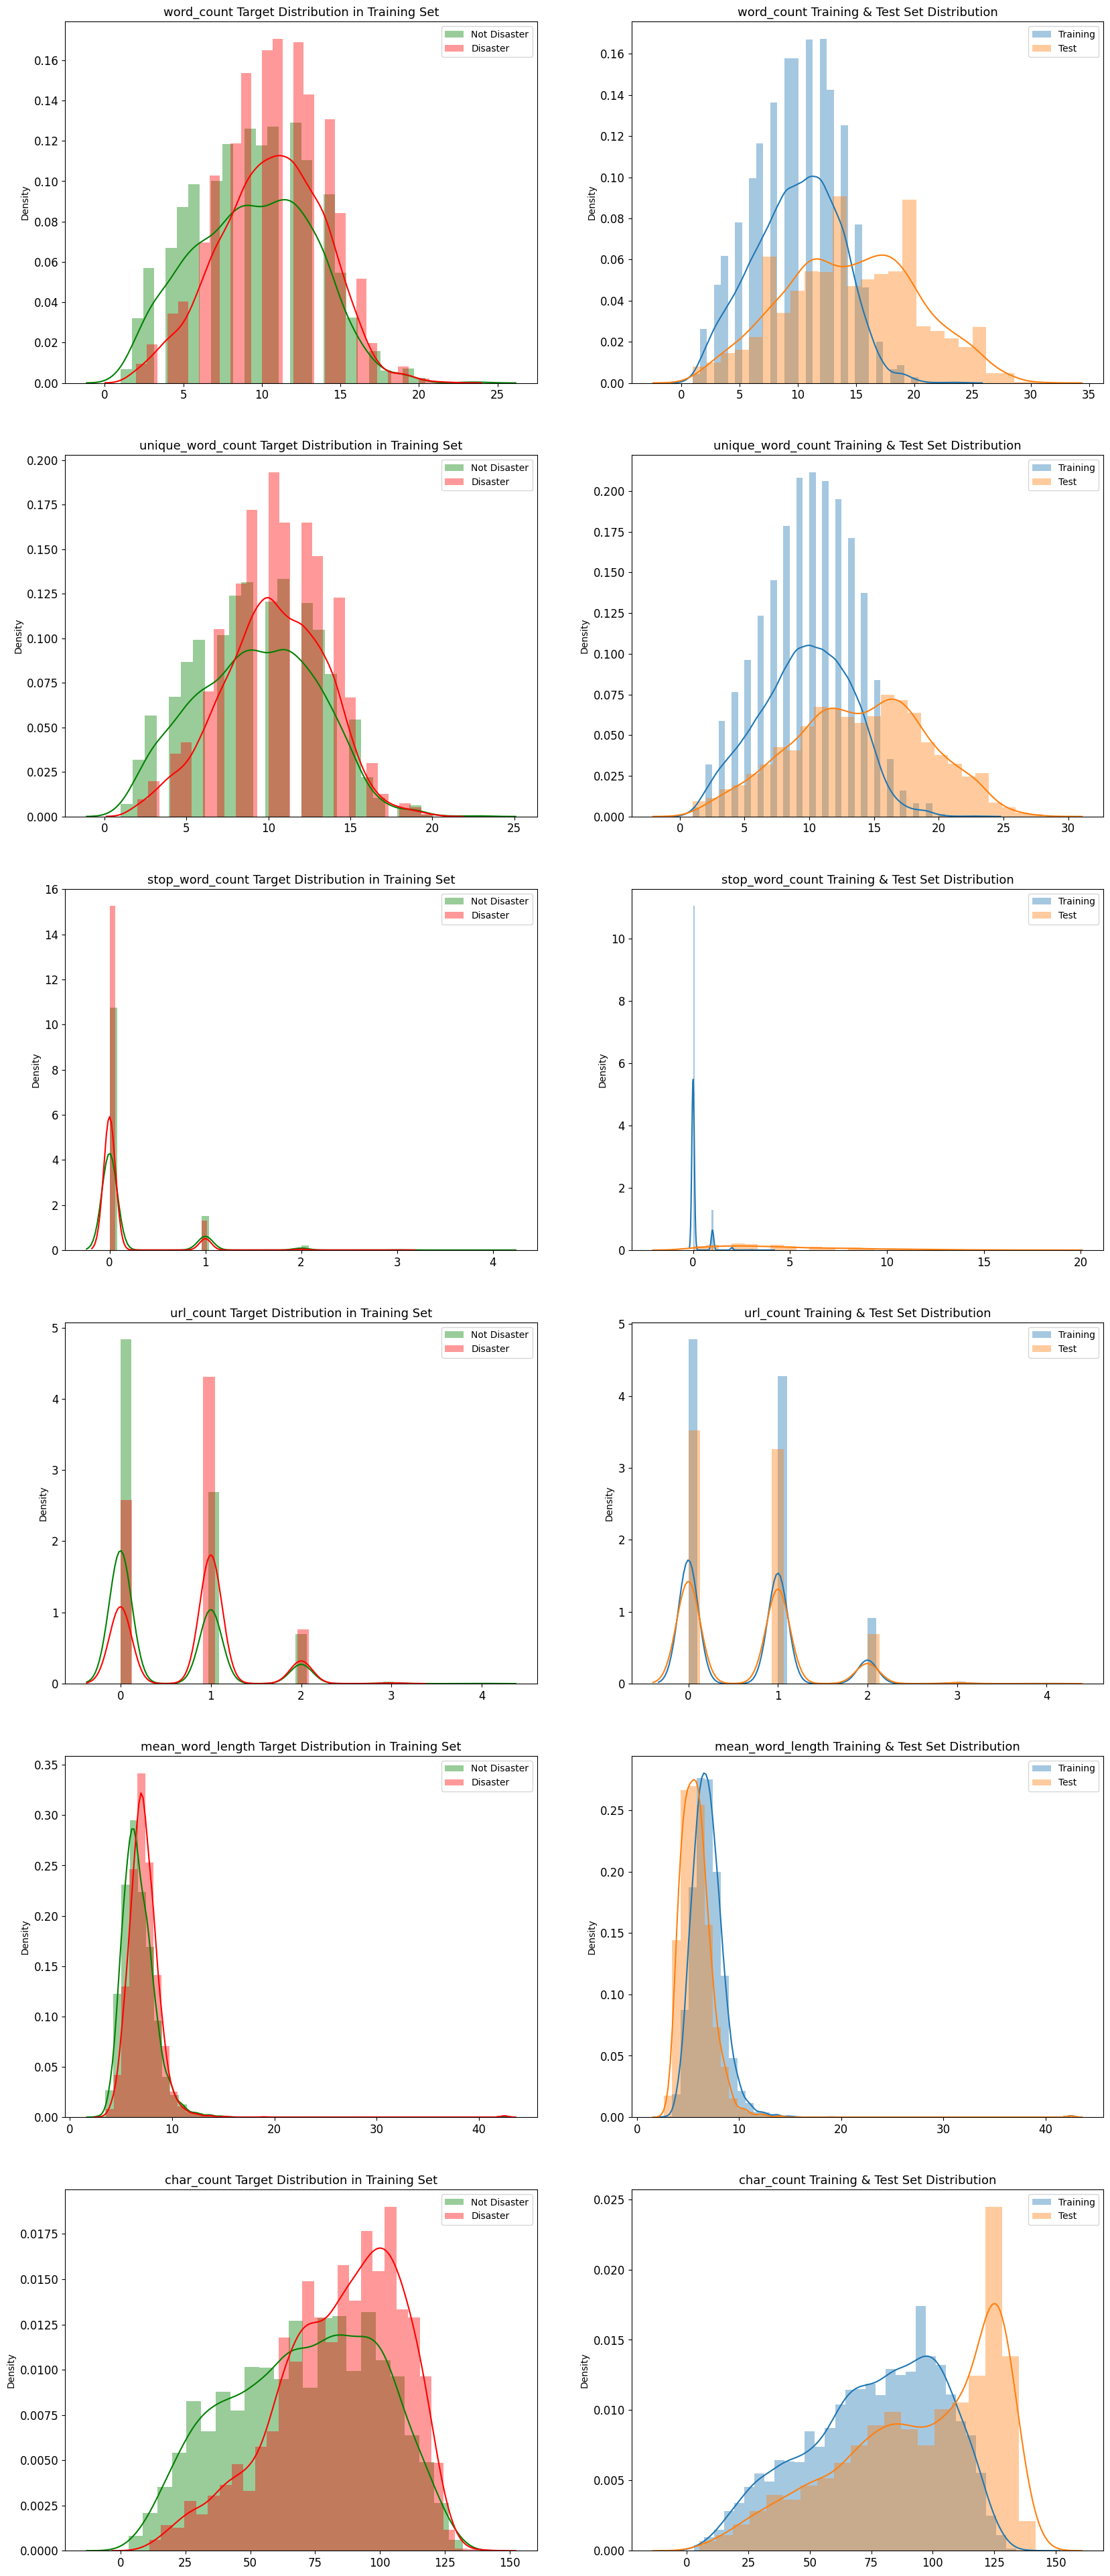

In [24]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = train_data['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_data.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

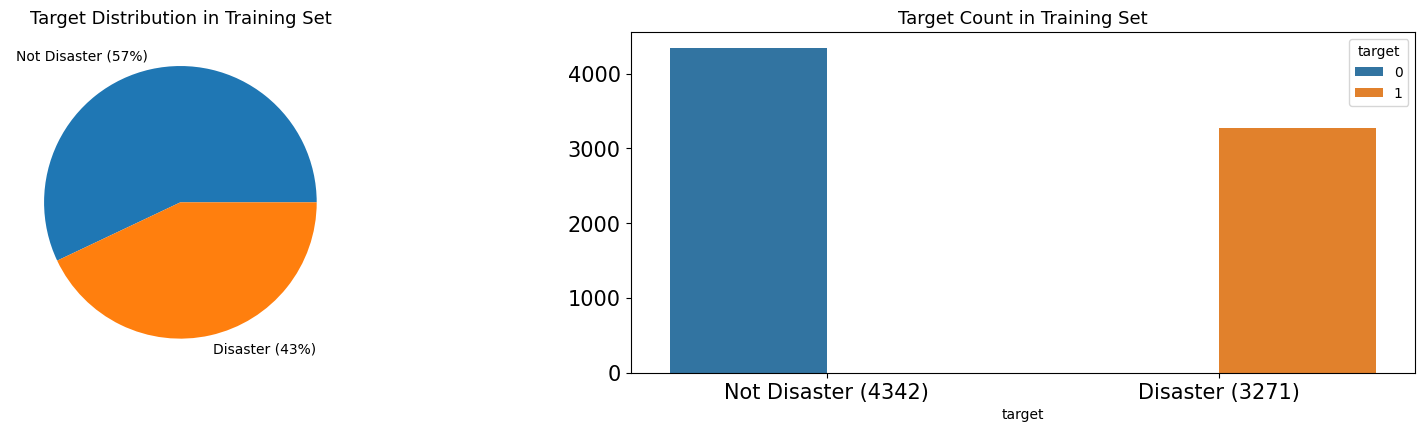

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_data.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train_data['target'], hue=train_data['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

# LSTM MODEL

In [26]:
train_data.head()

,id,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,1,deeds reason earthquake may allah forgive us,1,7,7,0,0,5.428571,44
1,4,forest fire near la ronge sask canada,1,7,7,0,0,4.428571,37
2,5,residents asked shelter place notified officer...,1,11,9,0,0,7.090909,88
3,6,13000 people receive wildfires evacuation orde...,1,7,7,0,0,7.571429,59
4,7,got sent photo ruby alaska smoke wildfires pou...,1,9,9,0,0,5.222222,55


In [27]:
train_tweets = train_data['text'].values
train_target = train_data['target'].values
test_tweets = test_data['text'].values
# test_tweets  = test_data['text'].values
# test_target = train_data['target'].values

In [28]:
# def embed for model   
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [29]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences

texts = train_data['text']
target = train_data['target']

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xu663\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array([[4388,  753,  149, ...,    0,    0,    0],
       [  96,    3,  131, ...,    0,    0,    0],
       [1573, 1445, 1948, ...,    0,    0,    0],
       ...,
       [3191, 4380, 6674, ...,    0,    0,    0],
       [  17,  982, 3026, ...,    0,    0,    0],
       [ 116,  113,  408, ...,    0,    0,    0]])

In [30]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
embedding_dim = 100
embeddings_dictionary = dict()

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [31]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [32]:
from keras.models import Sequential
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 100)           2273000   
                                                                 
 bidirectional (Bidirectiona  (None, 24, 48)           24000     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 48)               0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 48)               192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                        

In [33]:
# Train the model

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 10,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.5691
Epoch 00001: val_loss improved from inf to 0.68752, saving model to model.h5
179/179 [==============================] - 28s 140ms/step - loss: 0.6898 - accuracy: 0.5691 - val_loss: 0.6875 - val_accuracy: 0.5699 - lr: 0.0010
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5705
Epoch 00002: val_loss improved from 0.68752 to 0.68516, saving model to model.h5
179/179 [==============================] - 25s 140ms/step - loss: 0.6861 - accuracy: 0.5705 - val_loss: 0.6852 - val_accuracy: 0.5699 - lr: 0.0010
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5705
Epoch 00003: val_loss improved from 0.68516 to 0.68397, saving model to model.h5
179/179 [==============================] - 25s 142ms/step - loss: 0.6844 - accuracy: 0.5705 - val_loss: 0.6840 - val_accuracy: 0.5699 - lr: 0.0010
Epoch 4/10
179/179 [============

In [34]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

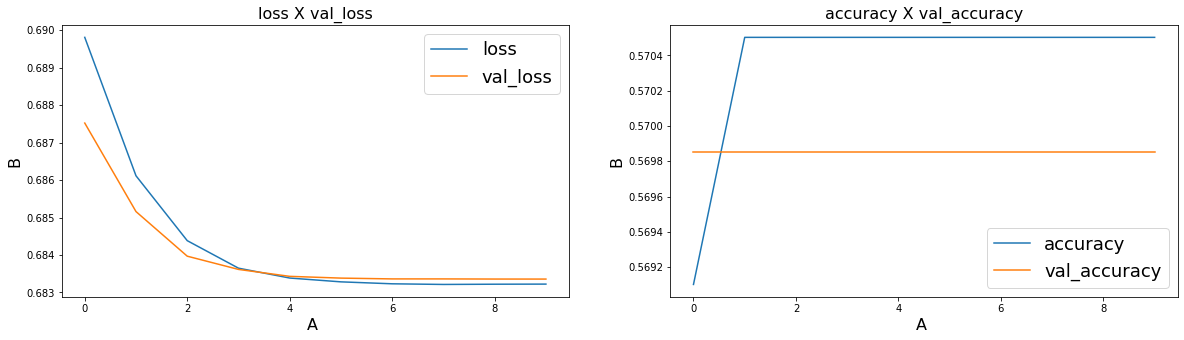

In [35]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [36]:
# visual_accuracy_and_loss(history)

In [37]:
yhat = (model.predict(X_test) > 0.5).astype("int32")
acc=[]
f1=[]
recall=[]
precision=[]
score_accuracy = accuracy_score(y_test, yhat)
score_f1 = f1_score(y_test, yhat)
score_recall = recall_score(y_test, yhat)
score_precision = precision_score(y_test, yhat)
acc.append(score_accuracy)
f1.append(score_f1)
# f1_score(y_test, yhat)
# lstm_score=metrics.accuracy_score(y_test, yhat)
print("LSTM's Accuracy:{0}".format(metrics.accuracy_score(y_test, yhat)))
print("LSTM's f1_score:{0}".format(metrics.f1_score(y_test, yhat)))
print("LSTM's recall:{0}".format(metrics.recall_score(y_test, yhat)))
print("LSTM's precision:{0}".format(metrics.precision_score(y_test, yhat)))

LSTM's Accuracy:0.5698529411764706
LSTM's f1_score:0.0
LSTM's recall:0.0
LSTM's precision:0.0


# BERT MODEL

BERT - Bidirectional Encoder Representations from Transformers

 LOADING BERT MODEL

In [38]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [39]:
tokenizer('onl01-dtsc-pt-062821')

{'input_ids': [101, 2006, 2140, 24096, 1011, 26718, 11020, 1011, 13866, 1011, 5757, 22407, 17465, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [40]:
print("max len of tweets",max([len(x.split()) for x in train_data.text]))
max_length = 36

max len of tweets 24


In [41]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [42]:
y_train = train_data.target.values

In [43]:
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Import data in model

In [44]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

# for training bert our lr must be so small

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                            

In [46]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

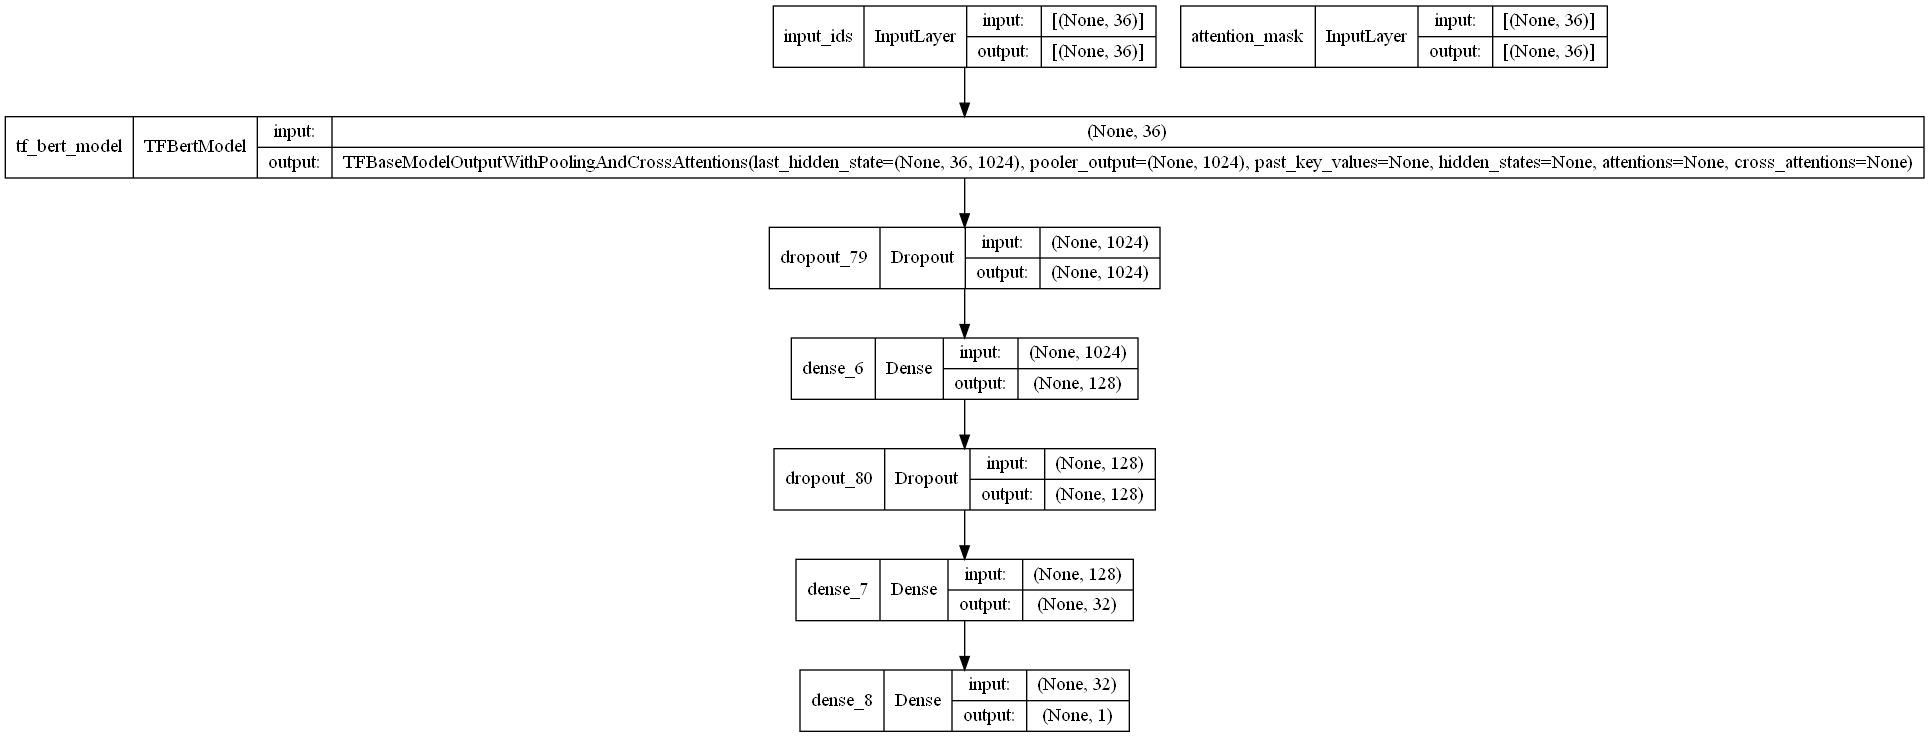

In [47]:
plot_model(model, show_shapes = True)

## Fit the model

In [48]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_split=0.2,
#     epochs=1,
    epochs=10,
    batch_size=10
)

Epoch 1/10
609/609 [==============================] - 96s 134ms/step - loss: 0.5541 - accuracy: 0.7312 - val_loss: 0.4566 - val_accuracy: 0.8122
Epoch 2/10
609/609 [==============================] - 80s 131ms/step - loss: 0.4522 - accuracy: 0.8130 - val_loss: 0.4395 - val_accuracy: 0.8175
Epoch 3/10
609/609 [==============================] - 80s 132ms/step - loss: 0.4268 - accuracy: 0.8263 - val_loss: 0.4300 - val_accuracy: 0.8221
Epoch 4/10
609/609 [==============================] - 80s 132ms/step - loss: 0.4080 - accuracy: 0.8338 - val_loss: 0.4372 - val_accuracy: 0.8168
Epoch 5/10
609/609 [==============================] - 81s 133ms/step - loss: 0.4040 - accuracy: 0.8384 - val_loss: 0.4337 - val_accuracy: 0.8181
Epoch 6/10
609/609 [==============================] - 80s 132ms/step - loss: 0.3984 - accuracy: 0.8401 - val_loss: 0.4348 - val_accuracy: 0.8188
Epoch 7/10
609/609 [==============================] - 80s 131ms/step - loss: 0.3889 - accuracy: 0.8473 - val_loss: 0.4313 - val_ac

This is running results showing below:
Epoch 1/9
762/762 [==============================] - 127s 139ms/step - loss: 0.5276 - accuracy: 0.7609
Epoch 2/9
762/762 [==============================] - 106s 139ms/step - loss: 0.4376 - accuracy: 0.8223
Epoch 3/9
762/762 [==============================] - 107s 141ms/step - loss: 0.4161 - accuracy: 0.8290
Epoch 4/9
762/762 [==============================] - 107s 141ms/step - loss: 0.4069 - accuracy: 0.8337
Epoch 5/9
762/762 [==============================] - 109s 144ms/step - loss: 0.3987 - accuracy: 0.8373
Epoch 6/9
762/762 [==============================] - 106s 140ms/step - loss: 0.3891 - accuracy: 0.8430
Epoch 7/9
762/762 [==============================] - 107s 140ms/step - loss: 0.3884 - accuracy: 0.8403
Epoch 8/9
762/762 [==============================] - 107s 140ms/step - loss: 0.3898 - accuracy: 0.8463
Epoch 9/9
762/762 [==============================] - 108s 142ms/step - loss: 0.3789 - accuracy: 0.8518

In [50]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']
    epochs_plot = np.arange(1, len(loss) + 1)
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

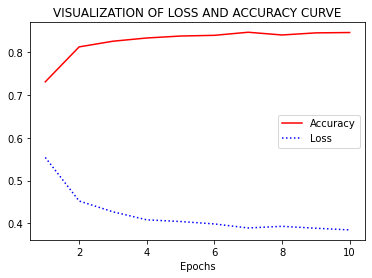

In [51]:
visual_accuracy_and_loss(final)

## Plot the loss and accuracy curves 

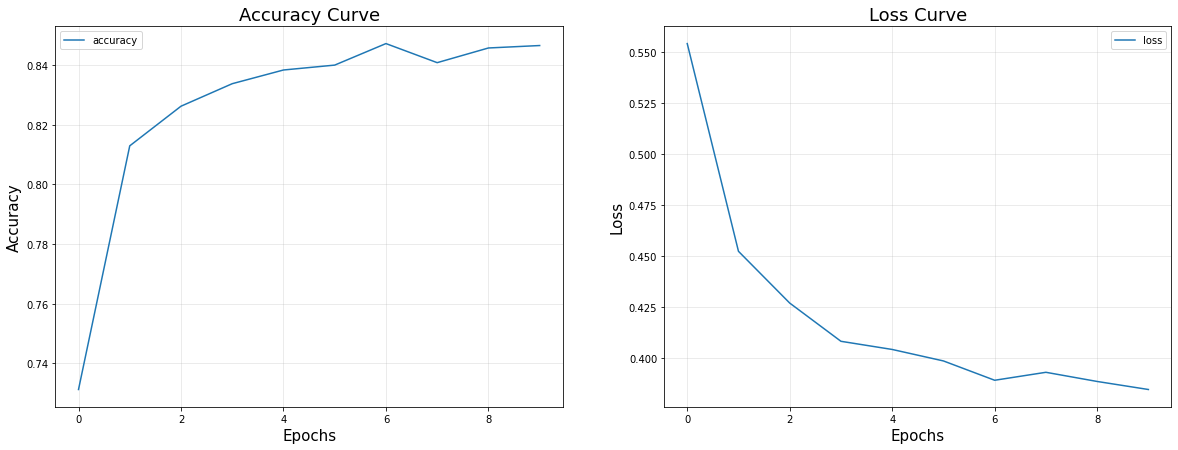

In [52]:
# Plot the loss and accuracy curves  

#Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(final.epoch,final.history['accuracy'],label = "accuracy") # Accuracy curve 


plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(final.epoch,final.history['loss'],label="loss") # Loss curve 


plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

# Conclusion

After analysis, my team believe this BERT is suitable for NLP on Twitter. And accuracy can be improved to 0.85 through iteration.​

We come into conclusion as below：​

Bert generate better accuracy results compared to LSTM with same iteration times, even though Bert cost more calculation time.​

By using our model, we successfully help tracing the emergency event by NLP. ​

In order to increasing accuracy, we can adding more balanced features like time, location, and etc.

# Future work

1. With more time, I would like to dig into relationship between NLP models and make a  clear comparison.​

2. For other media content, we can try to fit the model and find results as well.​

3. I want to see if we can add image processing to capture the emergency.